In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import seaborn as sns
from datetime import date
import time
from math import ceil

In [2]:
#read the csv into a pandas dataframe
df = pd.read_csv('/Users/raffi/Desktop/galvanize/capstone_1/data/games.csv', delimiter = ',')

In [4]:
#dropping duplicated ids in dataframe
df.drop_duplicates(subset = ['id'], inplace = True)

In [5]:
#update moves column from string to list for future analysis
df.moves = df.moves.apply(lambda x: x.split(' '))

In [6]:
#categorize rating scale - 1517 below 1200, 12668 between 1400 - 2000, 1716 above 2000
#https://en.wikipedia.org/wiki/Chess_rating_system
#https://en.wikipedia.org/wiki/Elo_rating_system
#beginner < 1400 : 4729
#novice 1200 - 1999 : 12668
#expert 2000 - 2200 : 1169
#master > 2200 : 547

#df[(df['white_rating'] >= 2000) & (df['white_rating'] < 2200)].count()
#df[df['white_rating'] >= 2200].count()
#df[df['white_rating'] < 1400].count()

#categorize rating scales
def rating_cat_value(val):
    if val < 1400:
        return 'Beginner'
    elif val < 2000:
        return 'Novice'
    elif val < 2200:
        return 'Expert'
    elif val >= 2200:
        return 'Master'
    
def rating_cat_code(val):
    if val < 1400:
        return 1
    elif val < 2000:
        return 2
    elif val < 2200:
        return 3
    elif val >= 2200:
        return 4

df['white_rating_value'] = df['white_rating'].apply(rating_cat_value)
df['black_rating_value'] = df['black_rating'].apply(rating_cat_value)
df['white_rating_code'] = df['white_rating'].apply(rating_cat_code)
df['black_rating_code'] = df['black_rating'].apply(rating_cat_code)

In [7]:
#creating new column for main opening line - used to filter through variations
def opening_strip(opening):
    if ':' in opening:
        opening = opening.split(':')[0]
    while '|' in opening:
        opening = opening.split('|')[0]
    if '#' in opening:
        opening = opening.split('#')[0]
    if 'Accepted' in opening:
        opening = opening.replace('Accepted', '')
    if 'Declined' in opening:
        opening = opening.replace('Declined', '')
    if 'Refused' in opening:
        opening = opening.replace('Refused', '')
    return opening.strip()

df['main_opening'] = df['opening_name'].apply(opening_strip)

In [8]:
#creating two numerical columns for white win True / False and black win True / False
def white_winner(winner):
    if winner == 'white':
        return 1
    else:
        return 0

def black_winner(winner):
    if winner == 'black':
        return 1
    else:
        return 0 

def no_winner(winner):
    if winner == 'draw':
        return 1
    else:
        return 0 
    
df['white_winner'] = df['winner'].apply(white_winner)
df['black_winner'] = df['winner'].apply(black_winner)
df['no_winner'] = df['winner'].apply(no_winner)

In [9]:
#adding new column of data - date
date = pd.to_datetime(df['created_at'], errors = 'ignore', unit = 'ms')
df['date'] = pd.DatetimeIndex(date).date

In [20]:
datedf = df.copy()
datedf.index = pd.to_datetime(datedf['date'])
op = datedf.groupby(by = datedf.index.year).agg({'opening_ply': 'mean'})
turns = datedf.groupby(by = datedf.index.year).agg({'turns': 'mean'})
rating = datedf.groupby(by = datedf.index.year).agg({'white_rating': 'mean'})
v_status = datedf.groupby(by = datedf.index.year).agg({'victory_status' : 'count'})

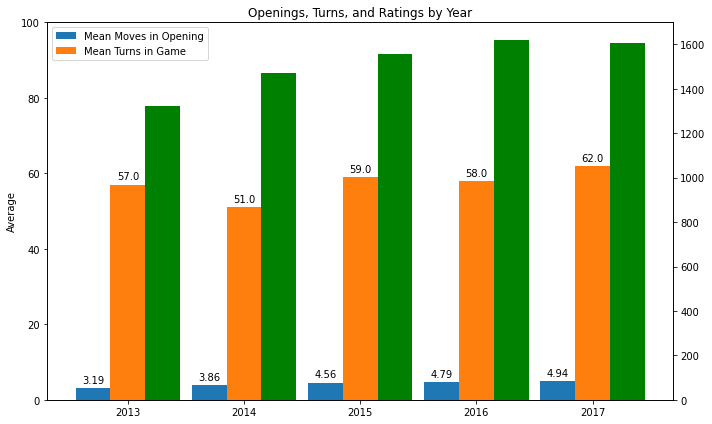

In [71]:
labels = ['2013', '2014', '2015', '2016', '2017']
x = np.arange(len(labels))
width = 0.30
fig, ax = plt.subplots(figsize = (10,6))
ax2 = ax.twinx()
rects1 = ax.bar(x - width, op.opening_ply.round(2), width, label = 'Mean Moves in Opening')
rects2 = ax.bar(x, turns.turns.round(0), width, label = 'Mean Turns in Game')
rects3 = ax2.bar(x + width, rating.white_rating.round(0), width, label = 'Mean Turns in Game', color = 'g')

ax.set_ylabel('Average')
ax.set_title('Openings, Turns, and Ratings by Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(top = 100)

ax.legend(loc = 'upper left')

def autolabel(rects):
    '''Attach a text label above each bar'''
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                   xy = (rect.get_x() + rect.get_width() / 2, height),
                   xytext = (0, 3), 
                   textcoords = 'offset points',
                   ha = 'center', va = 'bottom')


#height3 = rects3.get_height()        
#ax3.annotate('{}'.format(height3), xy = (rects3.get_x() + rects3.get_width() / 2, height3),
#             xytext = (0,3), textcoords = 'offset points', ha = 'center', va = 'bottom')

autolabel(rects1)
autolabel(rects2)
# autolabel(rects3)

fig.tight_layout()

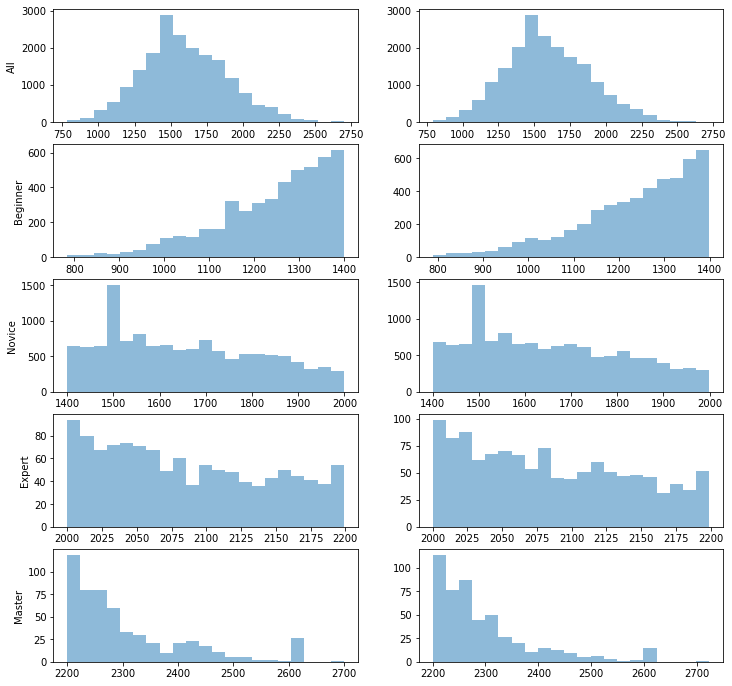

In [78]:
#distribution of ratings by group
fig,axs = plt.subplots(5,2, figsize = (12,12))
bins = 21
wb = df[df['white_rating_value'] == 'Beginner']
wn = df[df['white_rating_value'] == 'Novice']
we = df[df['white_rating_value'] == 'Expert']
wm = df[df['white_rating_value'] == 'Master']
bb = df[df['black_rating_value'] == 'Beginner']
bn = df[df['black_rating_value'] == 'Novice']
be = df[df['black_rating_value'] == 'Expert']
bm = df[df['black_rating_value'] == 'Master']
axs[0,0].hist(df['white_rating'], bins, alpha = 0.5, label = 'All White Ratings')
axs[0,0].set_ylabel('All')
axs[1,0].hist(wb['white_rating'], bins, alpha = 0.5)
axs[1,0].set_ylabel('Beginner')
axs[2,0].hist(wn['white_rating'], bins, alpha = 0.5)
axs[2,0].set_ylabel('Novice')
axs[3,0].hist(we['white_rating'], bins, alpha = 0.5)
axs[3,0].set_ylabel('Expert')
axs[4,0].hist(wm['white_rating'], bins, alpha = 0.5)
axs[4,0].set_ylabel('Master')
axs[0,1].hist(df['black_rating'], bins, alpha = 0.5)
axs[1,1].hist(bb['black_rating'], bins, alpha = 0.5)
axs[2,1].hist(bn['black_rating'], bins, alpha = 0.5)
axs[3,1].hist(be['black_rating'], bins, alpha = 0.5)
axs[4,1].hist(bm['black_rating'], bins, alpha = 0.5);